In [1]:

# Libraries needed 

import pandas as pd
import numpy as np
import requests
import io
import re
import nltk  
import warnings

# download the required tokenizer
nltk.download('punkt') 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

# download the stopwords from NLTK
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Create stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

# Create Lemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.probability import FreqDist

import string
from collections import Counter


#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline
# Downloading the csv file from your GitHub account


url = "https://raw.githubusercontent.com/20j01acs029/csc423-midterm/main/nlp-project/nigerian_presidential_election_2023_tweets.csv" 
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe
df.head()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1.61762E+18,Fabulous Faga,"Abakaliki, Nigeria",🌹A Social media influencer\n💃A scientist by pr...,2020-10-19 08:02:47+00:00,244,999,686,FALSE,2023-01-23 20:24:20+00:00,#OBI and #wife storm kastina state today.\n\nS...,"['OBI', 'wife']",Twitter for Android,0.0,5.0,False
1,1.61765E+18,Patriotic Nigerian,"Lagos, Nigeria",inspiring and amazingly created. Marketing/ Br...,2021-03-30 22:04:11+00:00,688,2827,3488,FALSE,2023-01-23 22:20:47+00:00,"If they can’t point to you one project , inves...","['peterobi', 'Atiku']",Twitter for iPhone,11.0,15.0,False
2,1.61766E+18,Promise,NaN,Health and Fitness enthusiast,2022-05-06 23:03:08+00:00,2,22,40,FALSE,2023-01-23 22:54:22+00:00,@atiku God with his infinite mercy will never ...,NaN,Twitter for iPhone,0.0,0.0,False
3,1.61758E+18,KemKem,"Lagos, Nigeria",My Tweets & Views are Personal & do not\nrefle...,2015-01-01 07:40:09+00:00,24474,1931,129947,FALSE,2023-01-23 18:05:02+00:00,Governor @RotimiAkeredolu takes Asiwaju Bola A...,NaN,Twitter for Android,14.0,40.0,False
4,1.61762E+18,Mo'6icky,NaN,"By nature, an optimist_📌",2019-05-09 16:31:33+00:00,22,198,540,FALSE,2023-01-23 20:25:14+00:00,@atiku Salutation is not Love. #Obi is coming,['Obi'],Twitter for Android,0.0,4.0,False


In [2]:

#Spliting columns
df[['Id','col']] = df['id'].str.split('+',expand=True)

#Drop and rename columns
df = df.drop(columns=['user_created','user_verified','source', 'favorites','user_favourites','is_retweet','user_followers', 'col'])
df.rename(columns={
        'user_location': 'Location'
    }, inplace=True)

#Text processing

# Define a regular expression pattern to match URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')

# Remove URLs from all columns of the DataFrame
df = df.replace(to_replace=url_pattern, value='', regex=True)

# Define a regular expression pattern to match special characters and punctuations
special_char_pattern = re.compile(r'[^A-Za-z0-9 ]+')

# Remove special characters and punctuations from all columns of the DataFrame
df = df.replace(to_replace=special_char_pattern, value=' ', regex=True)

# Convert all text to lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

# Drop rows with missing values
df.dropna(inplace=True)
#Check null values
df.isnull().sum()

id                  0
user_name           0
Location            0
user_description    0
user_friends        0
date                0
text                0
hashtags            0
retweets            0
Id                  0
dtype: int64

In [3]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Define a tokenizer function
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens
# Create a new column in the DataFrame to hold the tokenized text
df['tokenized_text'] = ''
df['tokenized_text'] = df['text'].apply(tokenize_text)

# Define a function to remove stopwords from text
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens
df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)


def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#lemmatize requires list input
def lemmatize(unkn_input):
    if (isinstance(unkn_input,list)):
      list_input=unkn_input
    if (isinstance(unkn_input,str)):
      list_input=strg_list_to_list(unkn_input)
    list_sentence = [item.lower() for item in list_input]
    nltk_tagged = nltk.pos_tag(list_sentence)  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])),nltk_tagged)
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        #" ".join(lemmatized_sentence)
    return lemmatized_sentence
    df['tokenized_text'] = df['tokenized_text'].apply(lemmatize)

In [4]:
#Length of the dataset
print('length of data:', len(df))

length of data: 21470


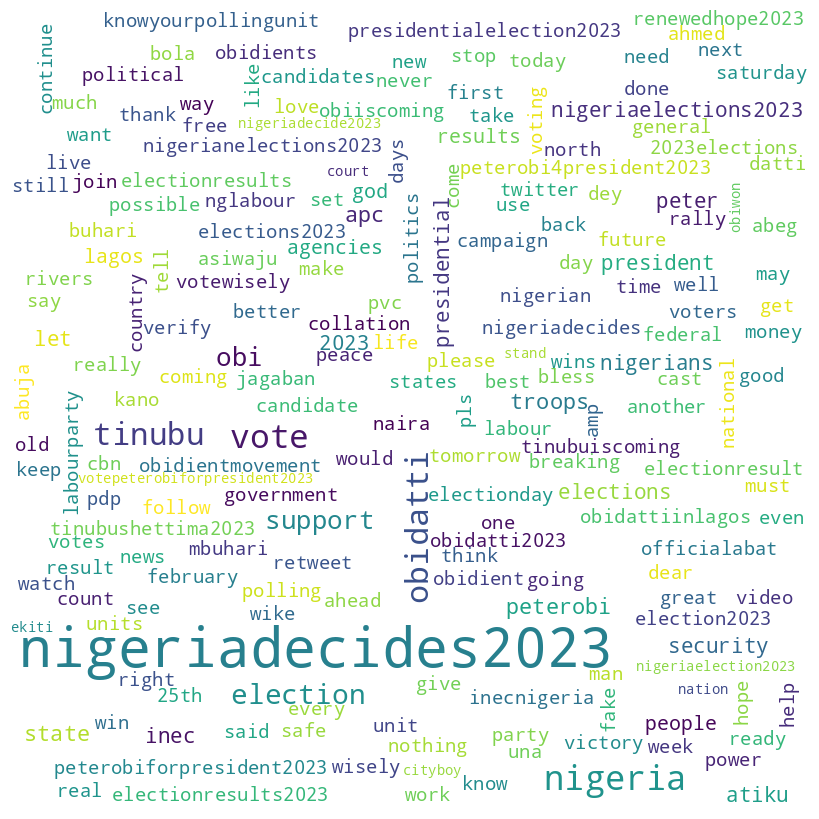

In [5]:

df['text_string'] = df['tokenized_text'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
word_freq = Counter(' '.join(df['text_string']).split())

# Create WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=200).generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [6]:
#Frequency distributions
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

words = nltk.word_tokenize(all_words)
fd = FreqDist(words)
fd.tabulate(3)

nigeriadecides2023            nigeria               vote 
             12090               2682               2578 


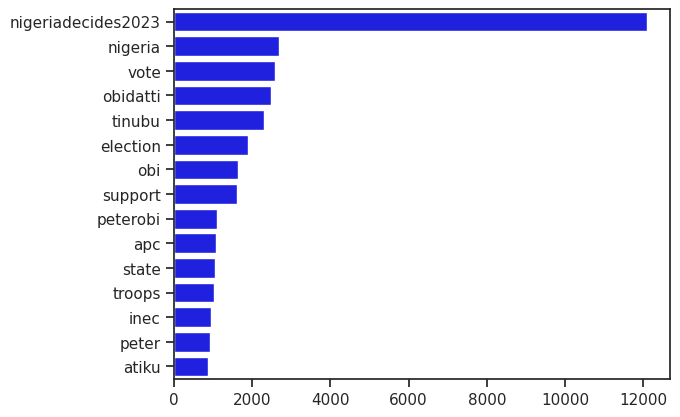

In [7]:
# Obtain top 15 words
top_15 = fd.most_common(15)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_15))
sns.set_theme(style="ticks")
sns.barplot(y=fdist.index, x=fdist.values, color='blue');

In [8]:
# Save DataFrame to CSV file
df.to_csv('new_file.csv', index=False)